In [22]:
import pandas as pd
import numpy as np
import json
import pickle
# data viz imports
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
import seaborn as sns
# time-series imports
from datetime import datetime
# imports for xgboost
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, cv, plot_importance

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [23]:
login=pd.read_json(r'C:\Users\issam\OneDrive\Desktop\json\ultimate_challenge\logins.json')
# converting the dict to a dataframe object by setting the login as index 
# and counting each login count as a column 
login['log_count']=1
log=login.set_index(pd.to_datetime(login['login_time'],unit='s'))[['log_count']]
log.head()


,log_count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [24]:
log_15=log.resample('15Min').sum()
log_15.head()

,log_count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


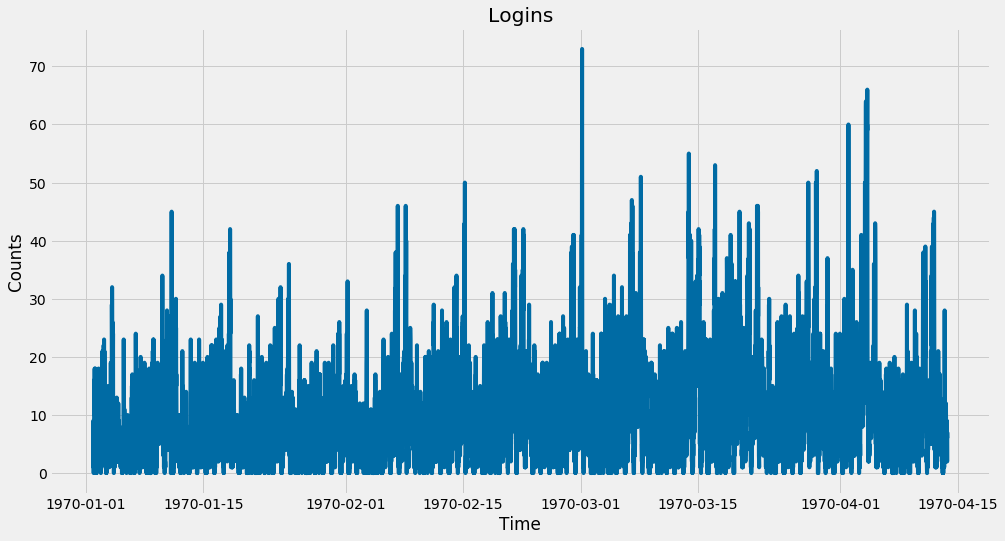

In [25]:
fig,ax=plt.subplots(figsize=(15,8))
plt.title('Logins')
plt.xlabel('Time')
plt.ylabel('Counts')
plt.plot(log_15)
plt.show()

The resulting chart show seasonality so a sanity check for seasonality is next


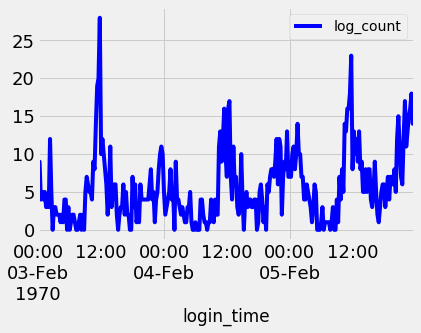

In [59]:
#plt.style.use('fivethirtyeight')

df_subset=log_15['1970-02-03':'1970-02-05']
_=df_subset.plot(color='blue',fontsize=18)
plt.show()

__The above plot shows that the data has a kind ot pattern weekly so it is s good approach to dive deeper and to resample the dataframe we have into different dataframes daily, business days and weekends and let us plot theses data frames and try to analyse the pattern__.

In [27]:
log_15_daily = log_15.resample('D').sum()
log_15_biz_day = log_15.resample('B').sum()
fridays = log_15.resample('W-FRI').sum()
saturdays = log_15.resample('W-SAT').sum()
sundays = log_15.resample('W-SUN').sum()

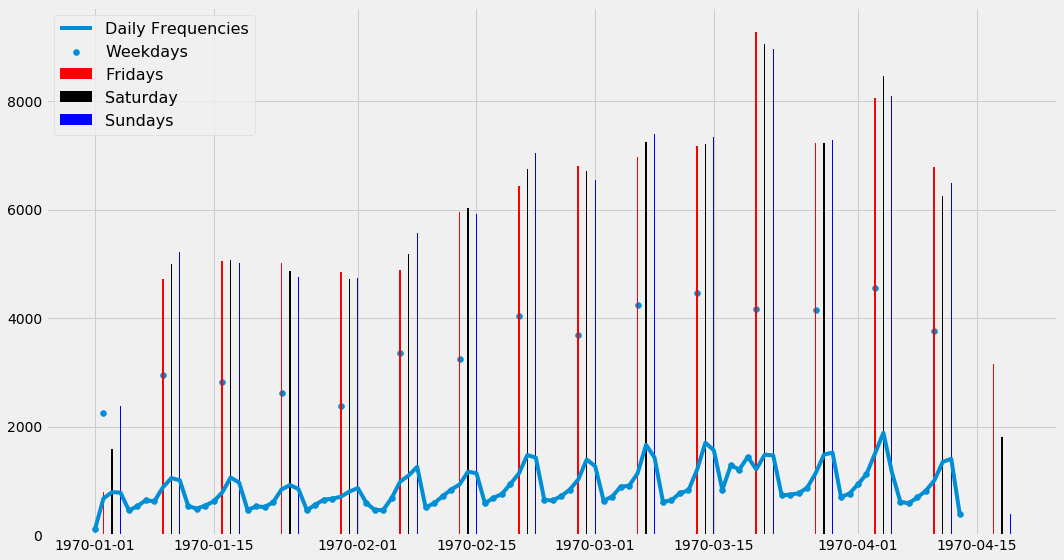

In [60]:
plt.style.use('fivethirtyeight')
fig,ax=plt.subplots(figsize=(15,8))
plt.bar(fridays.index, fridays.log_count, align= 'center', width = 0.2, label = "Fridays", color = 'R')
plt.bar(saturdays.index, saturdays.log_count, label = 'Saturday', align = 'center', width = 0.15, color = 'Black')
plt.bar(sundays.index, sundays.log_count, label = "Sundays", align= 'center', width = 0.1, color = 'B')
plt.plot(log_15_daily.index, log_15_daily.log_count, label = 'Daily Frequencies')
plt.scatter(log_15_biz_day.index, log_15_biz_day.log_count, label='Weekdays')

plt.legend(loc='upper left', fontsize = 16)
plt.tight_layout()


__The above plot shows that the logins are more on weekends than on weekdays and consistent  on Fridays__

__let us dive now to the hourly patterns of the logins__


In [29]:
# resampling the data to daily hourly logins
daily_log=log_15.resample('H').sum()
# breaking the dataframes into days of the week
week_days=list(daily_log.index.dayofweek)
# add it to the daily_log
daily_log['week_days']=week_days
# a column for the hors of each day
daily_log['hour']=[time.hour for time in daily_log.index]
# now creating the dataframe of weekdays hourly login
avg_hour_log=pd.pivot_table(daily_log,values='log_count',index='hour',
                  columns='week_days',aggfunc=np.mean).rename(columns=
                           {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})
avg_hour_log=avg_hour_log.stack(level=['week_days'])
avg_hour_log.name='avg_num_logins'
avg_hour_log_df=avg_hour_log.reset_index()

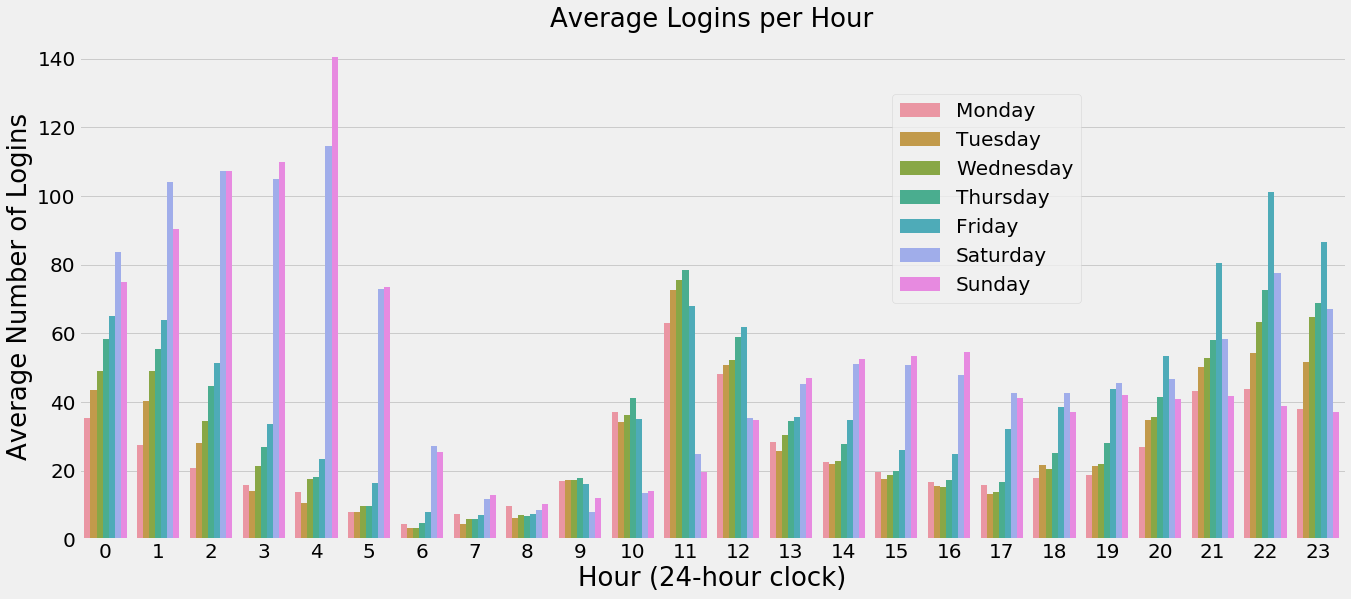

In [30]:
sns.catplot(x='hour', y='avg_num_logins', data=avg_hour_log_df, kind = 'bar', 
            hue='week_days',height=8, aspect=11.7/5, legend=False)
ax = plt.gca()
ax.set_title('Average Logins per Hour', fontsize = 26)
ax.set_xlabel('Hour (24-hour clock)', fontsize = 26)
ax.set_ylabel('Average Number of Logins', fontsize = 26)
ax.tick_params(labelsize=20,labelcolor="black")
ax.legend(bbox_to_anchor=(0.7,0.7,0.1, 0.2),fontsize=20)

__The aabove plot states that saturday and sunday has the most login counts are on  saturday and sunday on early hours between  1 and 5 am__

# Part 2 ‑ Experiment and metrics design

__The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities__>

__However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs__.

__What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric__?
__Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
how you will implement the experiment
what statistical test(s) you will conduct to verify the significance of the observation
how you would interpret the results and provide recommendations to the city operations team along with any caveats__

# I will start solving this problem by stating what I am trying to measure or test:

__I am stating or measuring in case the average number of cars going on weekdays from Gotham to Metropolis and at night from Metropolis to Gotham__.
__To capture this I would need the count of the cars crossing the bridge both ways prior to the reimbursement plan and after the reimbursement plan for a period of time__

__Then the last part would be developing a hypothesis test to test the validity of the plan__.
 
__H0: There is no difference between the mean number of cars entering the bridge from Gotham during weekdays between 6 am and 6 pm, one  month  before reimbursements were offered and the mean number of cars one month  after reimbursements were offered__.

__H1: There is an increase between the average of the cars entering the bridge from Gotham during weekdays between 6 am and 6 pm,  one  month  before reimbursements were offered and the mean number of cars one month after reimbursements were offered__.

__H0: There is no difference between the mean number of cars entering the bridge from Metropolis during weekdays between 7 pm and 5 am, one  month  before reimbursements were offered and the mean number of cars one month  after reimbursements were offered__.

__H1: There is an increase between the average of the cars entering the bridge from Metropolis  during weekdays between 7 pm and 5 am,  one  month  before reimbursements were offered and the mean number of cars one month after reimbursements were offered__.

__Now I will run a one tail test and calculate the p-value in both cases in case the p-value is less than 0.05 in the first scenario from Gotham to Metropolis then  we have to reject the Null hypothesis H0 and accept the reimbursement plan hypothesis__.

__In case the p-value is greater than 0.05 then I have to accept the null hypothesis and reject the alternative Hypothesis and the reimbursement plan__.



# Part 3 ‑ Predictive modeling
__Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days__.

__We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate__.

__The data is in the attached file ultimate_data_challenge.json__.

__Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained__?
__Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice)__.
# Assumptions Made
__The date of when the data was pulled is not given, so I cannot tell if they had a trip in the 30 days before that date, nor is a user ID given. Thus, I will assume:
That the most recent trip taken was the day the data was pulled
Each row represents a summary of a unique user__

In [31]:

with open(r'C:\Users\issam\OneDrive\Desktop\json\ultimate_challenge/ultimate_data_challenge.json') as f:
    data = json.load(f)
df=pd.DataFrame(data)


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [33]:
df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [34]:
df.isnull().sum().sort_values()

avg_dist                     0
avg_surge                    0
city                         0
last_trip_date               0
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
ultimate_black_user          0
weekday_pct                  0
avg_rating_by_driver       201
phone                      396
avg_rating_of_driver      8122
dtype: int64

In [35]:
df.describe

<bound method NDFrame.describe of        avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  \
0          3.67                   5.0                   4.7       1.10   
1          8.26                   5.0                   5.0       1.00   
2          0.77                   5.0                   4.3       1.00   
3          2.36                   4.9                   4.6       1.14   
4          3.13                   4.9                   4.4       1.19   
5         10.56                   5.0                   3.5       1.00   
6          3.95                   4.0                   NaN       1.00   
7          2.04                   5.0                   5.0       1.00   
8          4.36                   5.0                   4.5       1.00   
9          2.37                   5.0                   NaN       1.00   
10         4.28                   4.9                   5.0       1.00   
11         3.81                   5.0                   4.0       1.00   
12  

In [36]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [41]:
# let us do some data wangling is converting some object type data to date type objects 

df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

# Now we are to look for trips in the last thirty days as a clue for retention 
# so we are interested in the last thirty days data
data_date=df.last_trip_date.max()
effect_date=data_date-pd.Timedelta('30 days')
# creating a bollian feature for retention as defined last trip date 
df['active_status']=(df.last_trip_date>effect_date).astype('int')
df = pd.get_dummies(df, columns = ['city', 'phone'])
# finding two diffrent status active and incative users out of the the Status                               
active_user=df[df.active_status==1]
inactive_user=df[df.active_status==0]                              
                              

In [42]:
# let us draw some infrential statistics from active users
perc_active_users=round(len(active_user.active_status)/len(df.active_status)*100,2)
perc_active_users

36.62

__So 36.62 percent of the status are active users__

In [43]:

# calculate the mean and standard deviation for each feature
feature_columns = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
 'surge_pct', 'ultimate_black_user', 'weekday_pct', 'city_Astapor',
 "city_King's Landing", 'city_Winterfell', 'phone_Android','phone_iPhone']
stats_dict = {}
for col in feature_columns:
    stats_dict[col] = [active_user[col].mean(), active_user[col].std(),
                       inactive_user[col].mean(),inactive_user[col].std()]

In [44]:
# create a dataframe of the statistics
stats_df = pd.DataFrame.from_dict(stats_dict, orient='index').rename(columns = {0:'active_mean', 1:'active_std',
                                                                                2:'inactive_mean', 3:'inactive_std'})

Text(0.5, 1.0, 'Average of Features for Active and Inactive Users')

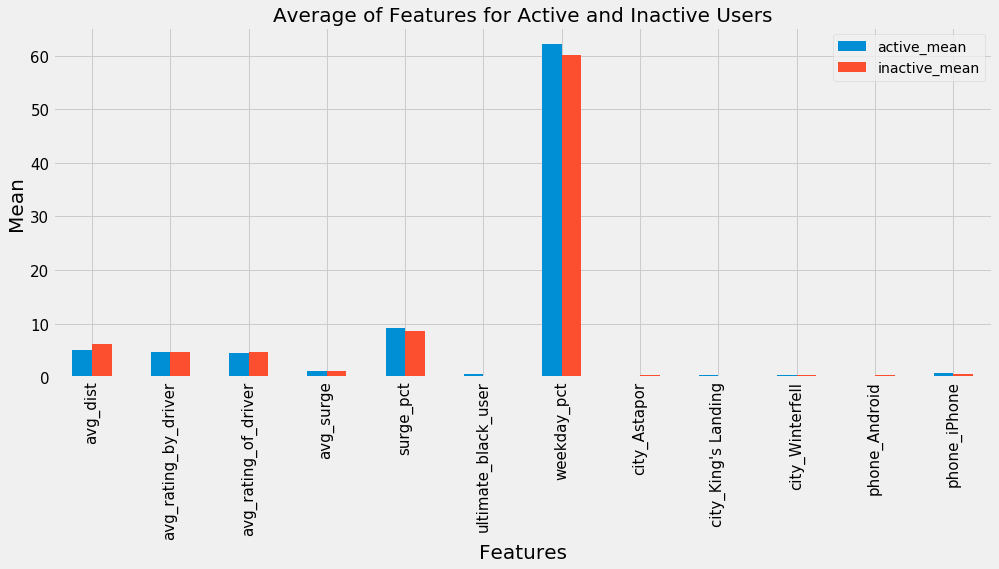

In [45]:
# visualize the statistics
stats_df[['active_mean', 'inactive_mean']].plot(kind = 'bar', yerr=stats_df[['active_std','inactive_std']], figsize = (15,6), fontsize = 15)
plt.xlabel('Features',fontsize = 20)
plt.ylabel('Mean', fontsize = 20)
plt.title('Average of Features for Active and Inactive Users', fontsize = 20)

#  XGBoost Classifer Model

__split data into training and test sets__                                                          
__optimize hyperparameters using the training set and random crossfold validation__                   
__validate using an unoptimized model AND the test set__                                             
__train optimized model using the entire feature set__                                                   

In [46]:
# define features and target
X = df[feature_columns]
y = df.active_status
# split training and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=123)

In [47]:

# dictionary of parameters to optimize, and the range of optimization values
parameters = {
    'max_delta_step':[0,0.05],
    'scale_pos_weight':[0.95, 0.9],
    'subsample':[1,0.8],
    'learning_rate': [0.25, 0.2, 0.1],
    'min_child_weight':[0,1,2],
    'gamma':[1, 2, 3]
    }

In [48]:
# instantiate classifier
xg_clf = XGBClassifier(objective = 'binary:logistic', random_state = 42, silent = 1, n_estimators=10, max_depth= 8)

# RandomSearch
grid_search = GridSearchCV(param_grid= parameters, estimator = xg_clf, cv=3, scoring='accuracy')
grid_search.fit(X_train,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=8, min_child_weight=1,
                                     missing=None, n_estimators=10, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=1,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'gamma': [1, 2, 3], 'learning_rate': [0.25, 0.2, 0.1],
                         'max_delta_step': [0, 0.05],
                         'min_child_

In [49]:
# Print best parameters and results
print(grid_search.best_params_)
print(grid_search.best_score_)

{'gamma': 3, 'learning_rate': 0.25, 'max_delta_step': 0, 'min_child_weight': 1, 'scale_pos_weight': 0.95, 'subsample': 0.8}
0.7833142857142857


In [50]:
# optimized parameters
optimized_parameters = {'objective':'binary:logistic',
                        'n_estimators': 10,
                        'random_state': 42,
                        'silent': 0,
                        'subsample': 1, 
                        'scale_pos_weight': 0.95, 
                        'min_child_weight': 1, 
                        'max_depth': 8, 
                        'max_delta_step': 0, 
                        'learning_rate': 0.2, 
                        'gamma': 3
                       }

In [51]:
# instantiate classifier
xg_clf_opt = XGBClassifier(**optimized_parameters)
xg_clf_opt.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=3,
              learning_rate=0.2, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.95, seed=None,
              silent=0, subsample=1, verbosity=1)

In [52]:
# predict the labels
y_opt_pred = xg_clf_opt.predict(X_train)
# score model
score = accuracy_score(y_train, y_opt_pred)
# print accuracy
print("The resulting accuracy of the optimized classifier is {}.".format(round(score,4)))

The resulting accuracy of the optimized classifier is 0.8033.


In [53]:
# train unoptimized model
xg_clf.fit(X_train, y_train)
# predict the labels of unoptimized model
y_unopt_pred = xg_clf.predict(X_train)
# score model
un_score = accuracy_score(y_train, y_unopt_pred)
# print accuracy
print("The resulting accuracy of the unoptimized classifier is {}.".format(round(un_score,4)))

The resulting accuracy of the unoptimized classifier is 0.7969.


__As the above numbers suggests the optimized parameters model accuracy is better than the un optimized__

In [54]:
# predict the labels
y_opt_test = xg_clf_opt.predict(X_test)
# score model
test_score = accuracy_score(y_test, y_opt_test)
# print accuracy
print("The resulting accuracy of the optimized classifier for the test set is {}.".format(round(test_score,4)))

The resulting accuracy of the optimized classifier for the test set is 0.7873.


In [55]:
# predict the labels of unoptimized model using the test set
y_unopt_test = xg_clf.predict(X_train)
# score model
test_score = accuracy_score(y_train, y_unopt_test)
# print accuracy
print("The resulting accuracy of the unoptimized classifier is {}.".format(round(test_score,4)))

The resulting accuracy of the unoptimized classifier is 0.7969.


__The optimized model performs worse with the test set, which means it is overfitting. Therefore, I will train the final model with all of the data using the default values__

In [56]:
# instantiate classifier
xg_clf_final = XGBClassifier(objective = 'binary:logistic', random_state = 42, silent = 1, n_estimators=200, max_depth= 8)
# train final model
xg_clf_final.fit(X, y)
# save model
pickle.dump(xg_clf_final, open('final_model.pickle', 'wb'))

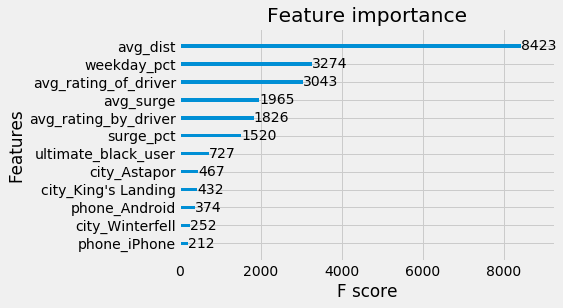

In [62]:
## ploting the important features 

plot_importance(xg_clf_final)

# Conclusions
__The default parameters produced the best performing XGBoost model, resulting in a classification accuracy of 85.43% for the test data. The factors that most heavily influence rider retention are the average distance in miles per trip taken in the first 30 days after signup and the percent of the user's trips occuring during a weekday__.